In [24]:
import os
import h5py
import tkinter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from data_import import import_ppd
from scipy.signal import savgol_filter
from scipy.stats import sem

### Process single PPD file

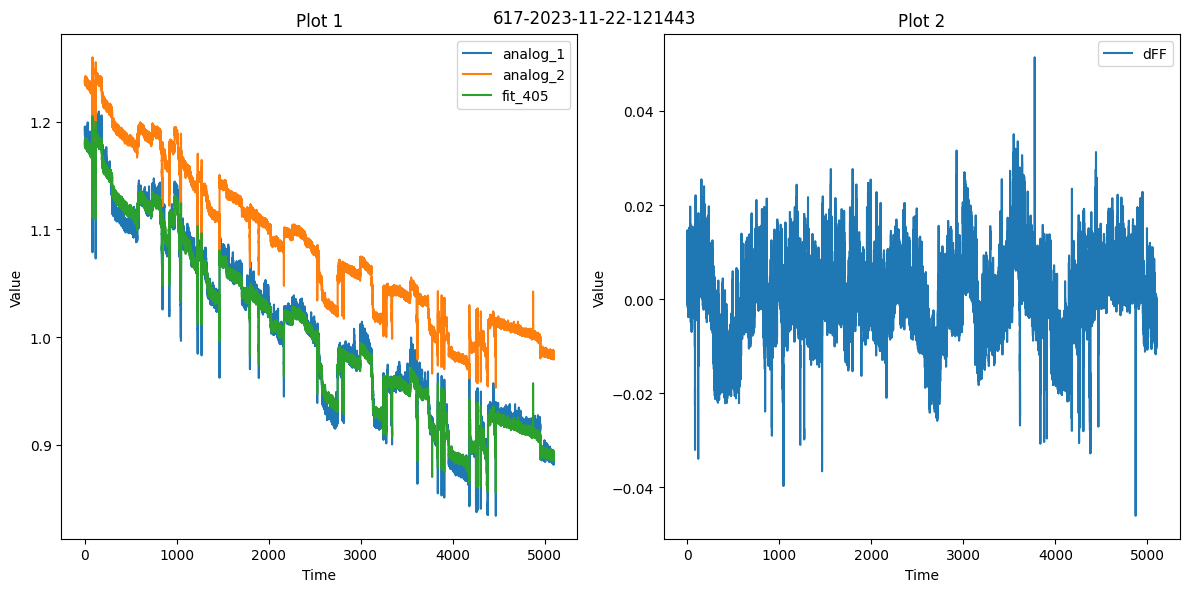

index: (array([1347, 1477, 2777, 2907], dtype=int64),)


In [10]:
# Define the PPD file path
ppd_file_path = r'C:\files\data\sensory_stim\fp\617-2023-11-22-121443.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


# Index of np.diff(data['digital_1']) bigger than 0.5 or smaller than -0.5
index = np.where((np.diff(data['digital_1']) > 0.5) | (np.diff(data['digital_1']) < -0.5))

# Print the onsets and offsets
print("index:", index)

dFF = dFF[index[0][0]:]


In [160]:
# Load the Excel file
file_path = 'C:\files\data/sensory_stim/JH617_log.xlsx'
excel_data = pd.read_excel(file_path)

# Extract the stimulus (Stim) value from the 'Event' column
excel_data['Stim'] = excel_data['Event'].apply(lambda x: int(x.split(':')[0]))

# Subtract 'ledonset' from the 'Frame' column and convert to string
ledonset = 502
fps = 30
excel_data['Time'] = ((excel_data['Frame'] - ledonset) / fps).astype(str)

# Organize data into a dictionary
data = {
    'Mouse617': {
        'Stim': excel_data['Stim'].tolist(),
        'Time': excel_data['Time'].tolist()
    }
}

# Use `data` as needed in your analysis

stim_data = data['Mouse617']['Stim']
time_stamps = data['Mouse617']['Time']
sampling_rate = 130
fps = 30

pinp_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
weak_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]
mild_indexes = [i for i, stim in enumerate(stim_data) if stim == 2]
hard_indexes = [i for i, stim in enumerate(stim_data) if stim == 3]
cold_indexes = [i for i, stim in enumerate(stim_data) if stim == 4]
room_indexes = [i for i, stim in enumerate(stim_data) if stim == 5]
warm_indexes = [i for i, stim in enumerate(stim_data) if stim == 6]

pinp_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in pinp_indexes]
weak_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in weak_indexes]
mild_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in mild_indexes]
hard_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in hard_indexes]
cold_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in cold_indexes]
room_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in room_indexes]
warm_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in warm_indexes]


trace_duration = 5  # 5 seconds before and 30 seconds after each data index

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Function to analyze and plot data for different index sets
def analyze_and_plot(indexes, dFF, sampling_rate, pre_start=5, post_start=10):
    trace_data_matrix = []

    for index in indexes:
        start = int(index - pre_start * sampling_rate)
        end = int(index + post_start * sampling_rate)
        trace_data = dFF[start:end]
        time = np.arange(start, end) / sampling_rate

        # Calculate the baseline value
        baseline_start = int(index - 5 * sampling_rate)
        baseline_end = int(index - 3 * sampling_rate)
        baseline = np.mean(dFF[baseline_start:baseline_end])

        # Compute the relative trace data
        relative_trace_data = trace_data - baseline

        # Append relative_trace_data to the matrix
        trace_data_matrix.append(relative_trace_data)


    return np.array(trace_data_matrix)

# Example usage for each data index set
trace_data_matrix_pinp = analyze_and_plot(pinp_data_indexes, dFF, sampling_rate)
trace_data_matrix_weak = analyze_and_plot(weak_data_indexes, dFF, sampling_rate)
trace_data_matrix_mild = analyze_and_plot(mild_data_indexes, dFF, sampling_rate)
trace_data_matrix_hard = analyze_and_plot(hard_data_indexes, dFF, sampling_rate)
trace_data_matrix_cold = analyze_and_plot(cold_data_indexes, dFF, sampling_rate)
trace_data_matrix_room = analyze_and_plot(room_data_indexes, dFF, sampling_rate)
trace_data_matrix_warm = analyze_and_plot(warm_data_indexes, dFF, sampling_rate)



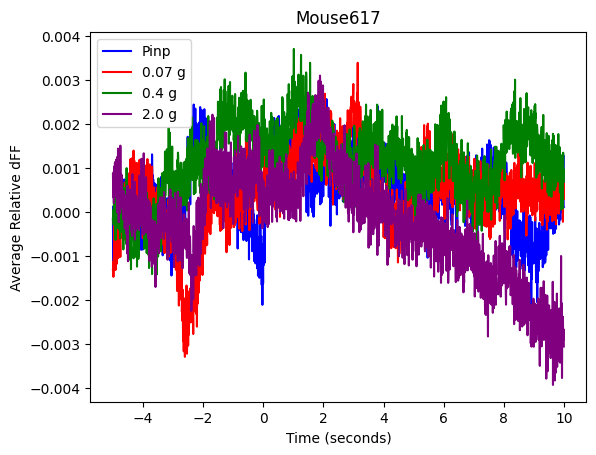

In [161]:
pre_start=5
post_start=10
# Calculate the average trace for water and TMT
average_trace_pinp = np.mean(trace_data_matrix_pinp, axis=0)
average_trace_weak = np.mean(trace_data_matrix_weak, axis=0)
average_trace_mild = np.mean(trace_data_matrix_mild, axis=0)
average_trace_hard = np.mean(trace_data_matrix_hard, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_pinp, label='Pinp', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_weak, label='0.07 g', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_mild, label='0.4 g', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_hard, label='2.0 g', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse617')
plt.legend()
plt.show()

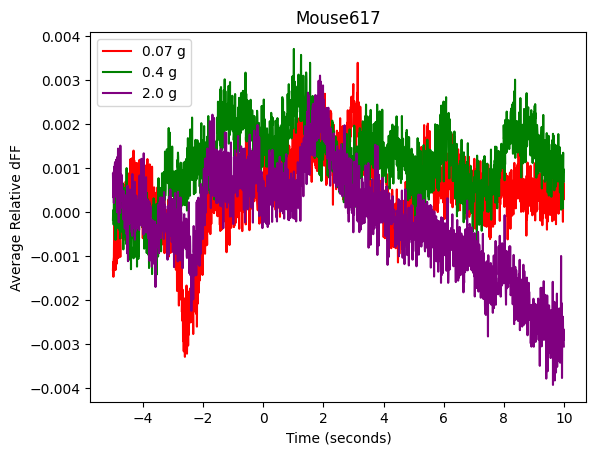

In [163]:
# Calculate the average trace for water and TMT
average_trace_pinp = np.mean(trace_data_matrix_pinp, axis=0)
average_trace_weak = np.mean(trace_data_matrix_weak, axis=0)
average_trace_mild = np.mean(trace_data_matrix_mild, axis=0)
average_trace_hard = np.mean(trace_data_matrix_hard, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_weak, label='0.07 g', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_mild, label='0.4 g', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_hard, label='2.0 g', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse617')
plt.legend()
plt.show()

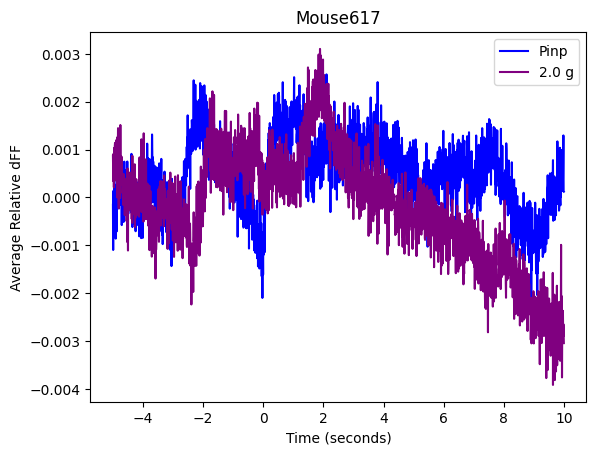

In [165]:
pre_start=5
post_start=10
# Calculate the average trace for water and TMT
average_trace_pinp = np.mean(trace_data_matrix_pinp, axis=0)
average_trace_weak = np.mean(trace_data_matrix_weak, axis=0)
average_trace_mild = np.mean(trace_data_matrix_mild, axis=0)
average_trace_hard = np.mean(trace_data_matrix_hard, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_pinp, label='Pinp', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_hard, label='2.0 g', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse617')
plt.legend()
plt.show()

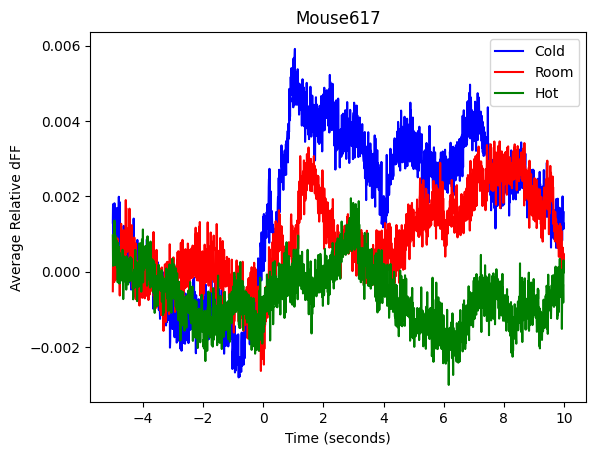

In [166]:
# Calculate the average trace for water and TMT
average_trace_cold = np.mean(trace_data_matrix_cold, axis=0)
average_trace_room = np.mean(trace_data_matrix_room, axis=0)
average_trace_warm = np.mean(trace_data_matrix_warm, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_cold, label='Cold', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_room, label='Room', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_warm, label='Hot', color='green')


plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse617')
plt.legend()
plt.show()

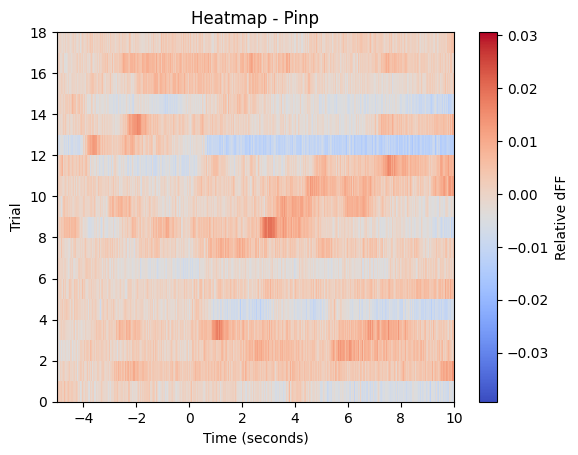

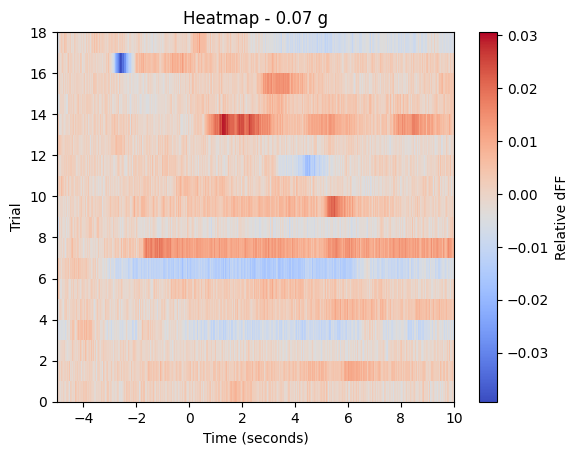

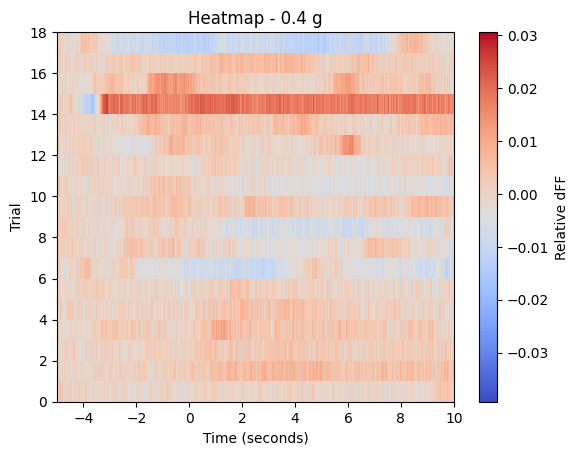

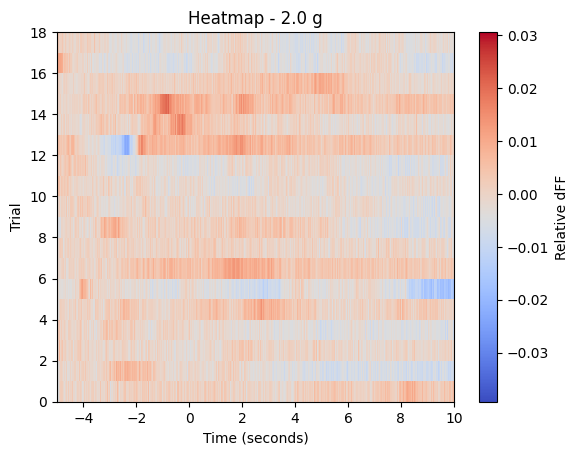

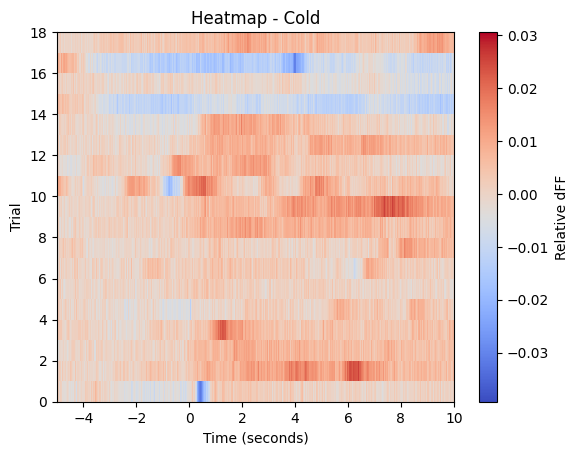

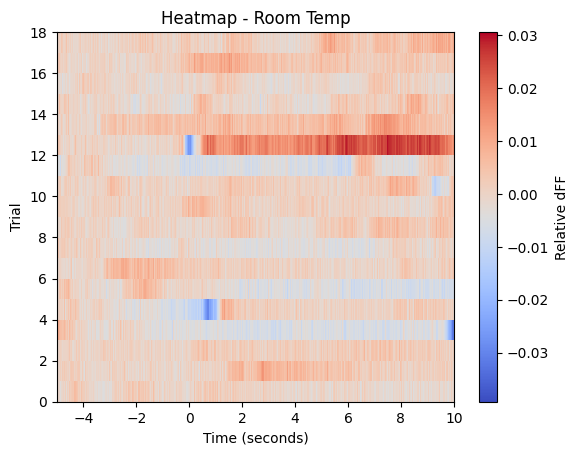

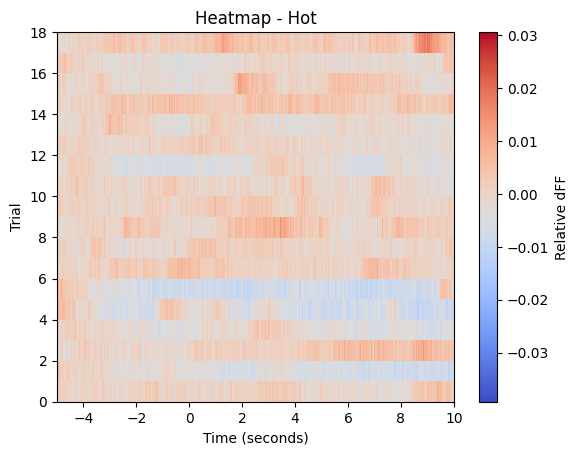

In [167]:
# Find global minimum and maximum values across all datasets for consistent color scaling
min_val = min(np.min(trace_data_matrix_pinp), np.min(trace_data_matrix_weak),
              np.min(trace_data_matrix_mild), np.min(trace_data_matrix_hard),
              np.min(trace_data_matrix_cold), np.min(trace_data_matrix_room),
              np.min(trace_data_matrix_warm))

max_val = max(np.max(trace_data_matrix_pinp), np.max(trace_data_matrix_weak),
              np.max(trace_data_matrix_mild), np.max(trace_data_matrix_hard),
              np.max(trace_data_matrix_cold), np.max(trace_data_matrix_room),
              np.max(trace_data_matrix_warm))

# Function to plot heatmap
def plot_heatmap(data_matrix, title, pre_start, post_start, sampling_rate, vmin, vmax):
    extent = [-pre_start, post_start, 0, data_matrix.shape[0]]
    plt.imshow(data_matrix, aspect='auto', extent=extent, cmap='coolwarm',
               interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Relative dFF')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Trial')
    plt.title(title)
    plt.show()

# Plotting heatmaps with consistent color scaling
plot_heatmap(trace_data_matrix_pinp, 'Heatmap - Pinp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_weak, 'Heatmap - 0.07 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_mild, 'Heatmap - 0.4 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_hard, 'Heatmap - 2.0 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_cold, 'Heatmap - Cold', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_room, 'Heatmap - Room Temp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_warm, 'Heatmap - Hot', pre_start, post_start, sampling_rate, min_val, max_val)


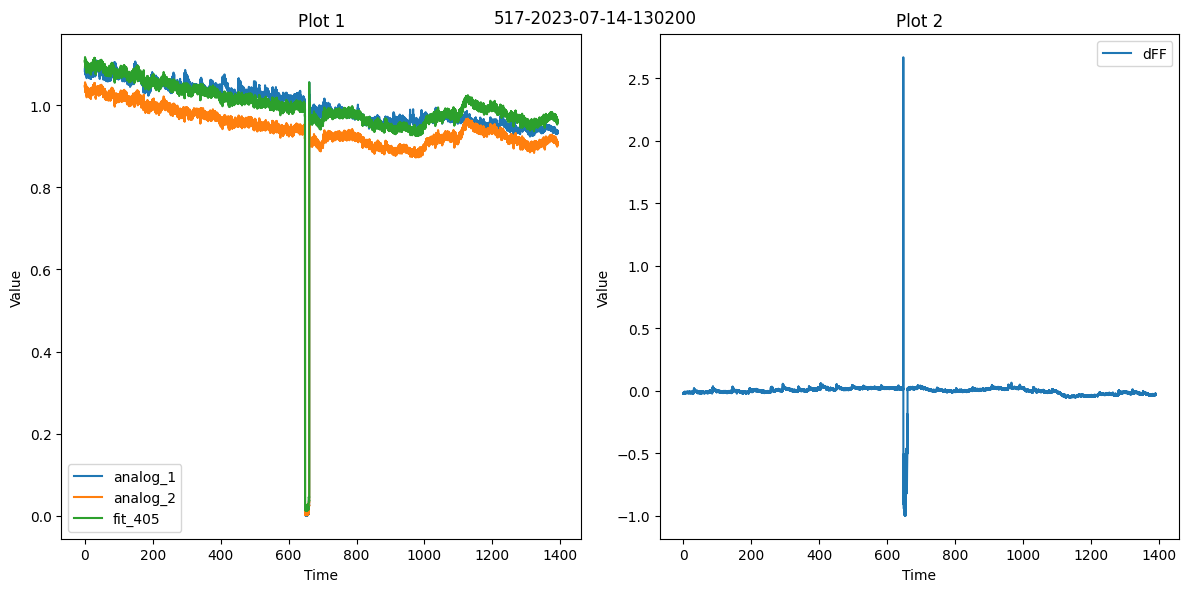

In [26]:
# Define the PPD file path
ppd_file_path = r'H:\fp_test\innate_fear\517-2023-07-14-130200.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


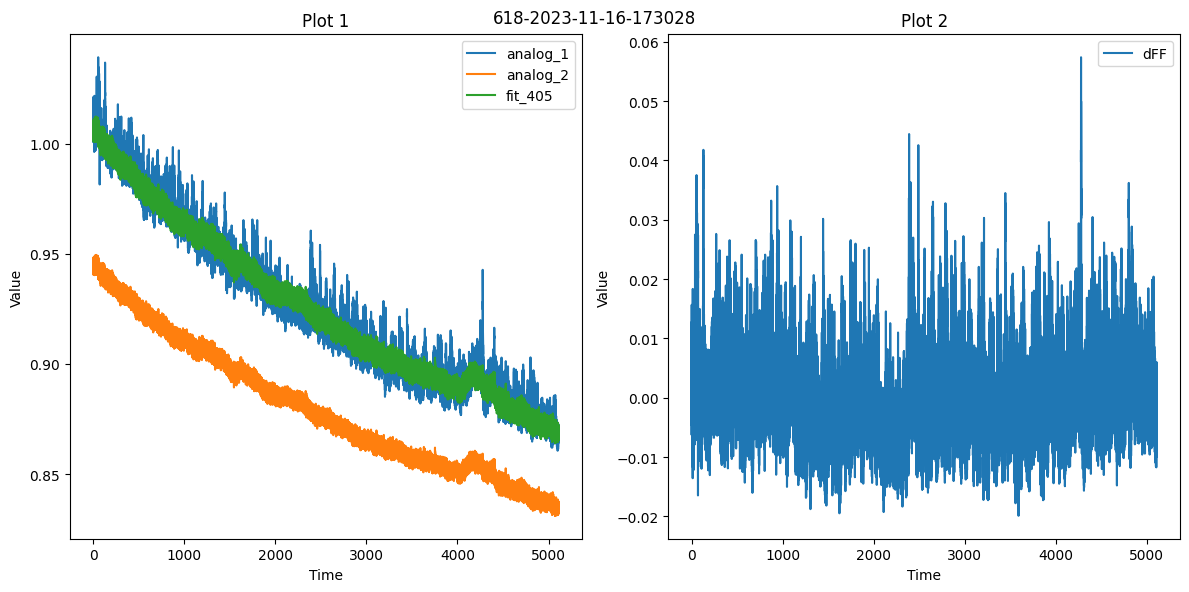

index: (array([1657, 1787, 3087, 3217], dtype=int64),)


In [173]:
# Define the PPD file path
ppd_file_path = r'C:\files\data\sensory_stim\fp\618-2023-11-16-173028.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


# Index of np.diff(data['digital_1']) bigger than 0.5 or smaller than -0.5
index = np.where((np.diff(data['digital_1']) > 0.5) | (np.diff(data['digital_1']) < -0.5))

# Print the onsets and offsets
print("index:", index)

dFF = dFF[index[0][0]:]


In [174]:
# Load the Excel file
file_path = 'C:\files\data/sensory_stim/JH618_log.xlsx'
excel_data = pd.read_excel(file_path)

# Extract the stimulus (Stim) value from the 'Event' column
excel_data['Stim'] = excel_data['Event'].apply(lambda x: int(x.split(':')[0]))

# Subtract 'ledonset' from the 'Frame' column and convert to string
ledonset = 2470
fps = 30
excel_data['Time'] = ((excel_data['Frame'] - ledonset) / fps).astype(str)

# Organize data into a dictionary
data = {
    'Mouse618': {
        'Stim': excel_data['Stim'].tolist(),
        'Time': excel_data['Time'].tolist()
    }
}

# Use `data` as needed in your analysis

stim_data = data['Mouse618']['Stim']
time_stamps = data['Mouse618']['Time']
sampling_rate = 130
fps = 30

pinp_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
weak_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]
mild_indexes = [i for i, stim in enumerate(stim_data) if stim == 2]
hard_indexes = [i for i, stim in enumerate(stim_data) if stim == 3]
cold_indexes = [i for i, stim in enumerate(stim_data) if stim == 4]
room_indexes = [i for i, stim in enumerate(stim_data) if stim == 5]
warm_indexes = [i for i, stim in enumerate(stim_data) if stim == 6]

pinp_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in pinp_indexes]
weak_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in weak_indexes]
mild_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in mild_indexes]
hard_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in hard_indexes]
cold_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in cold_indexes]
room_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in room_indexes]
warm_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in warm_indexes]


trace_duration = 5  # 5 seconds before and 30 seconds after each data index

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Function to analyze and plot data for different index sets
def analyze_and_plot(indexes, dFF, sampling_rate, pre_start=5, post_start=10):
    trace_data_matrix = []

    for index in indexes:
        start = int(index - pre_start * sampling_rate)
        end = int(index + post_start * sampling_rate)
        trace_data = dFF[start:end]
        time = np.arange(start, end) / sampling_rate

        # Calculate the baseline value
        baseline_start = int(index - 5 * sampling_rate)
        baseline_end = int(index - 3 * sampling_rate)
        baseline = np.mean(dFF[baseline_start:baseline_end])

        # Compute the relative trace data
        relative_trace_data = trace_data - baseline

        # Append relative_trace_data to the matrix
        trace_data_matrix.append(relative_trace_data)


    return np.array(trace_data_matrix)

# Example usage for each data index set
trace_data_matrix_pinp = analyze_and_plot(pinp_data_indexes, dFF, sampling_rate)
trace_data_matrix_weak = analyze_and_plot(weak_data_indexes, dFF, sampling_rate)
trace_data_matrix_mild = analyze_and_plot(mild_data_indexes, dFF, sampling_rate)
trace_data_matrix_hard = analyze_and_plot(hard_data_indexes, dFF, sampling_rate)
trace_data_matrix_cold = analyze_and_plot(cold_data_indexes, dFF, sampling_rate)
trace_data_matrix_room = analyze_and_plot(room_data_indexes, dFF, sampling_rate)
trace_data_matrix_warm = analyze_and_plot(warm_data_indexes, dFF, sampling_rate)



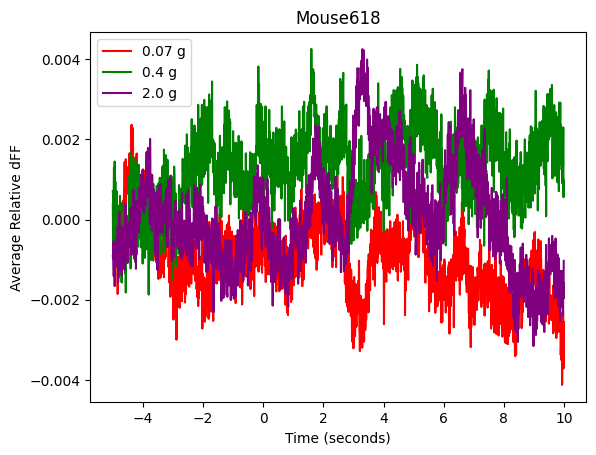

In [179]:
# Calculate the average trace for water and TMT
average_trace_pinp = np.mean(trace_data_matrix_pinp, axis=0)
average_trace_weak = np.mean(trace_data_matrix_weak, axis=0)
average_trace_mild = np.mean(trace_data_matrix_mild, axis=0)
average_trace_hard = np.mean(trace_data_matrix_hard, axis=0)

#plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_pinp, label='Pinp', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_weak, label='0.07 g', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_mild, label='0.4 g', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_hard, label='2.0 g', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse618')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (650,) and (0,)

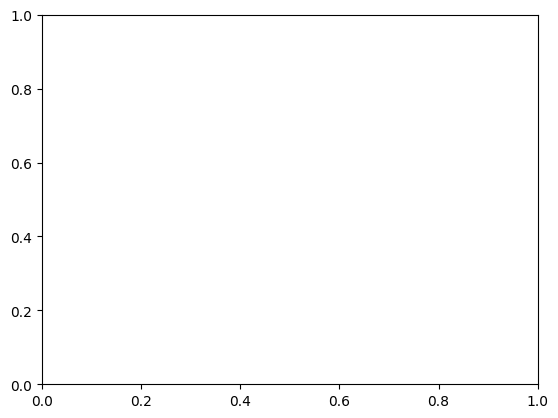

In [182]:
pre_start= 5
post_start = 10
# Calculate the average trace for water and TMT
average_trace_cold = np.mean(trace_data_matrix_cold, axis=0)
average_trace_room = np.mean(trace_data_matrix_room, axis=0)
average_trace_warm = np.mean(trace_data_matrix_warm, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_cold[-pre_start*sampling_ratC:\files\datapost_start*sampling_rate], label='Cold', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_room, label='Room', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_warm, label='Hot', color='green')


plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse618')
plt.legend()
plt.show()

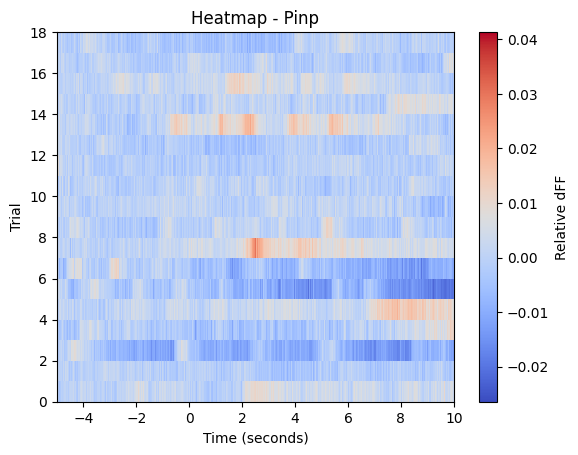

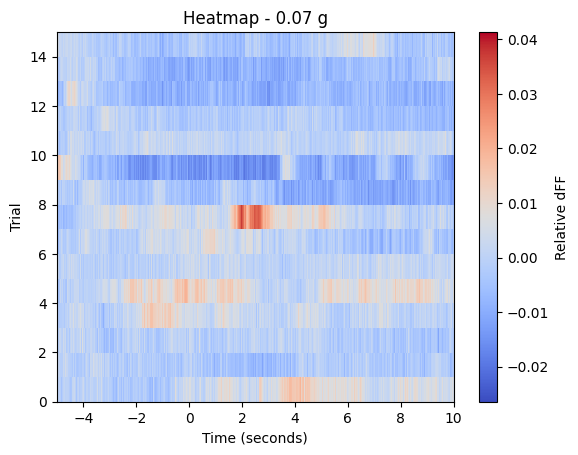

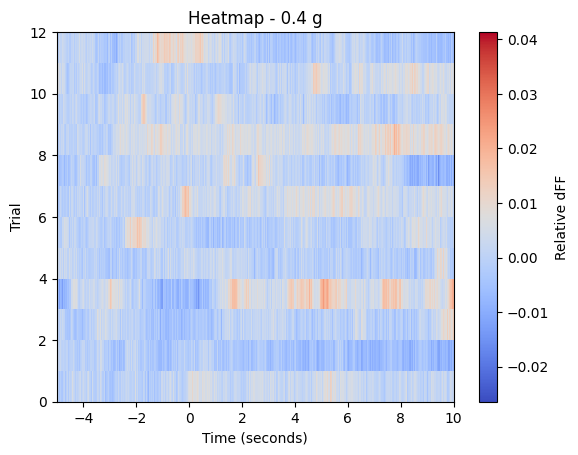

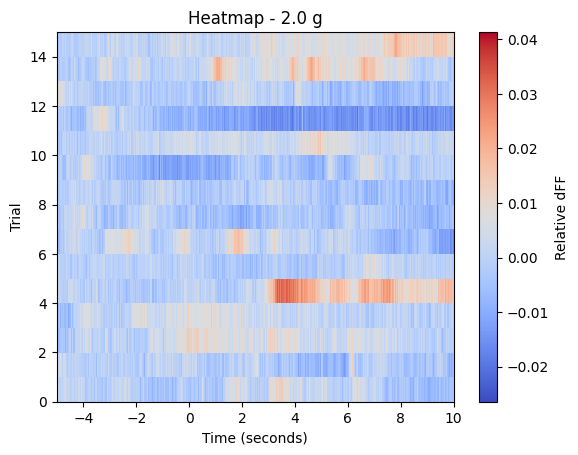

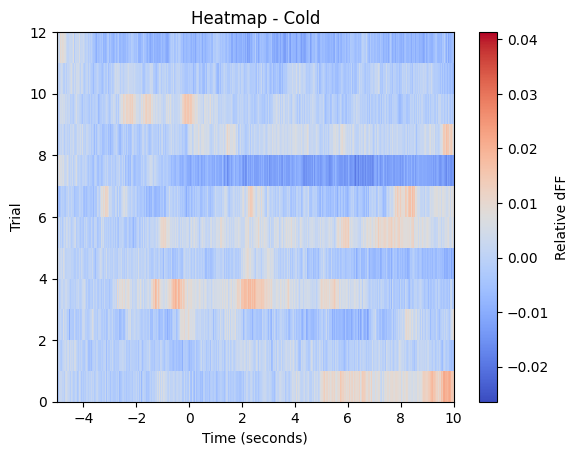

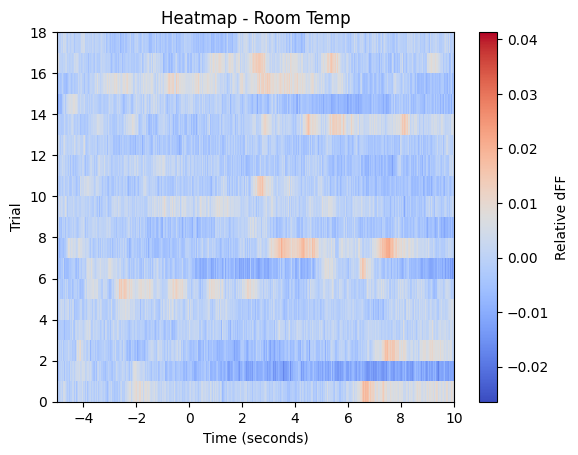

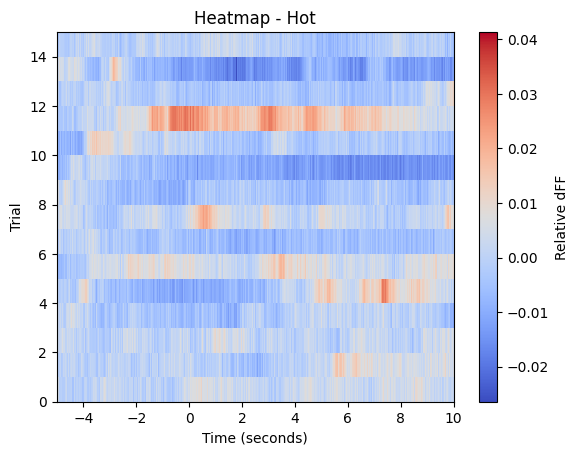

In [177]:
# Find global minimum and maximum values across all datasets for consistent color scaling
min_val = min(np.min(trace_data_matrix_pinp), np.min(trace_data_matrix_weak),
              np.min(trace_data_matrix_mild), np.min(trace_data_matrix_hard),
              np.min(trace_data_matrix_cold), np.min(trace_data_matrix_room),
              np.min(trace_data_matrix_warm))

max_val = max(np.max(trace_data_matrix_pinp), np.max(trace_data_matrix_weak),
              np.max(trace_data_matrix_mild), np.max(trace_data_matrix_hard),
              np.max(trace_data_matrix_cold), np.max(trace_data_matrix_room),
              np.max(trace_data_matrix_warm))

# Function to plot heatmap
def plot_heatmap(data_matrix, title, pre_start, post_start, sampling_rate, vmin, vmax):
    extent = [-pre_start, post_start, 0, data_matrix.shape[0]]
    plt.imshow(data_matrix, aspect='auto', extent=extent, cmap='coolwarm',
               interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Relative dFF')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Trial')
    plt.title(title)
    plt.show()

# Plotting heatmaps with consistent color scaling
plot_heatmap(trace_data_matrix_pinp, 'Heatmap - Pinp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_weak, 'Heatmap - 0.07 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_mild, 'Heatmap - 0.4 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_hard, 'Heatmap - 2.0 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_cold, 'Heatmap - Cold', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_room, 'Heatmap - Room Temp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_heatmap(trace_data_matrix_warm, 'Heatmap - Hot', pre_start, post_start, sampling_rate, min_val, max_val)


### Process single PPD file

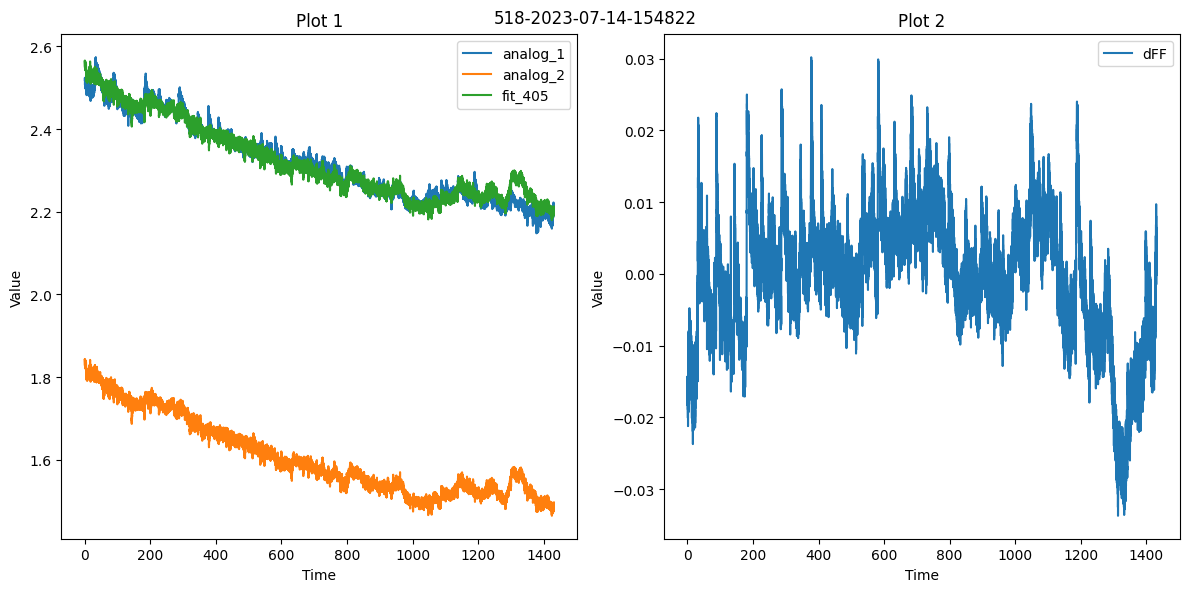

In [32]:
# Define the PPD file path
ppd_file_path = r'H:\fp_test\innate_fear\518-2023-07-14-154822.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


In [33]:
data = {
    'UniBe006': 
            {'Stim': [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1], 
             'Time': ['00:30', '01:25', '02:22', '03:00', '03:46', '04:45', '05:44', '06:16', '06:47', '07:19', 
                    '08:07', '08:53', '09:39', '10:30', '11:21', '12:06', '12:38', '13:16', '14:08', '14:57', 
                    '15:48', '16:40', '17:26', '18:04', '18:56', '19:49', '20:29', '21:22', '22:22', '23:17']}
}

stim_data = data['UniBe006']['Stim']
time_stamps = data['UniBe006']['Time']
sampling_rate = 130

def time_stamp_to_seconds(time_stamp):
    minutes, seconds = time_stamp.split(':')
    return int(minutes) * 60 + int(seconds)

water_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
tmt_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]

water_time_stamps = [time_stamps[i] for i in water_indexes]
tmt_time_stamps = [time_stamps[i] for i in tmt_indexes]

water_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in water_time_stamps]
tmt_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in tmt_time_stamps]

print("Water Indexes:", water_indexes)
print("Water Time Stamps:", water_time_stamps)
print("Water Data Indexes:", water_data_indexes)

print("TMT Indexes:", tmt_indexes)
print("TMT Time Stamps:", tmt_time_stamps)
print("TMT Data Indexes:", tmt_data_indexes)


Water Indexes: [0, 2, 4, 6, 7, 11, 12, 14, 16, 18, 22, 23, 24, 26, 28]
Water Time Stamps: ['00:30', '02:22', '03:46', '05:44', '06:16', '08:53', '09:39', '11:21', '12:38', '14:08', '17:26', '18:04', '18:56', '20:29', '22:22']
Water Data Indexes: [3900, 18460, 29380, 44720, 48880, 69290, 75270, 88530, 98540, 110240, 135980, 140920, 147680, 159770, 174460]
TMT Indexes: [1, 3, 5, 8, 9, 10, 13, 15, 17, 19, 20, 21, 25, 27, 29]
TMT Time Stamps: ['01:25', '03:00', '04:45', '06:47', '07:19', '08:07', '10:30', '12:06', '13:16', '14:57', '15:48', '16:40', '19:49', '21:22', '23:17']
TMT Data Indexes: [11050, 23400, 37050, 52910, 57070, 63310, 81900, 94380, 103480, 116610, 123240, 130000, 154570, 166660, 181610]


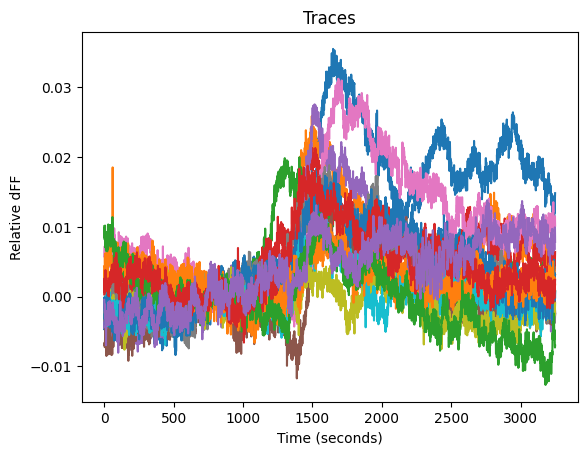

In [34]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in water_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_water = np.array(trace_data_matrix)


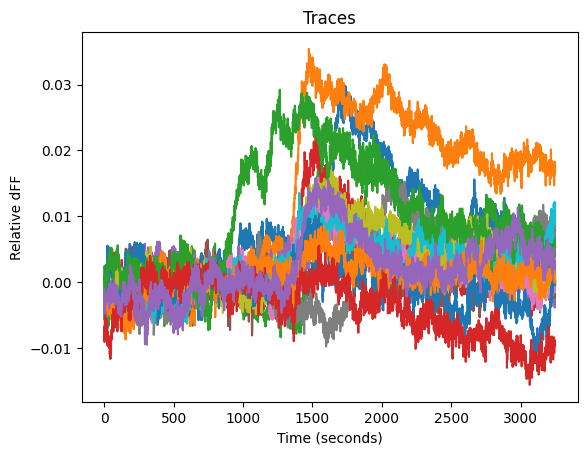

In [35]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in tmt_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_tmt = np.array(trace_data_matrix)


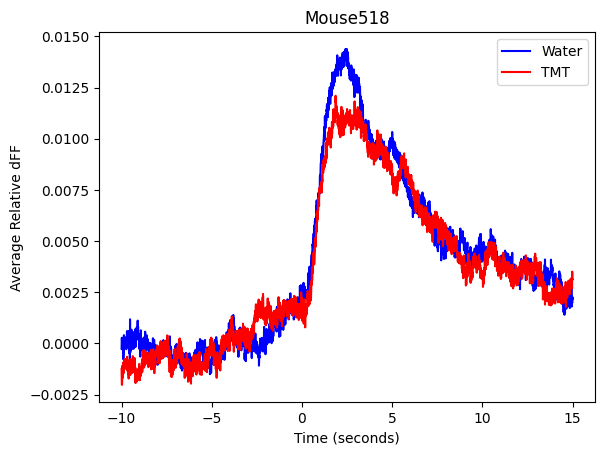

In [36]:
# Calculate the average trace for water and TMT
average_trace_water = np.mean(trace_data_matrix_water, axis=0)
average_trace_tmt = np.mean(trace_data_matrix_tmt, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water, label='Water', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt, label='TMT', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse518')
plt.legend()
plt.show()

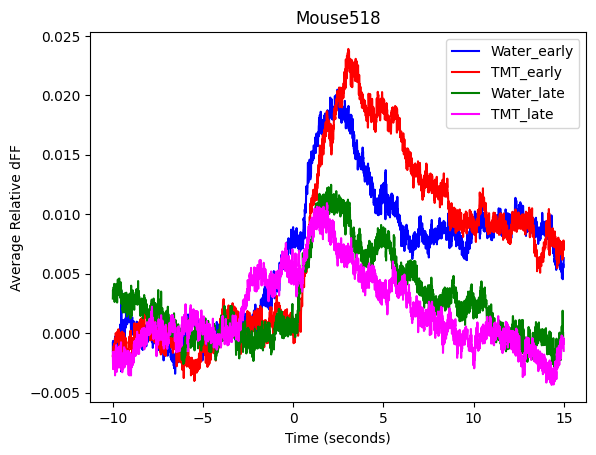

In [37]:
# Calculate the average trace for water and TMT
average_trace_water_early = np.mean(trace_data_matrix_water[0:4,:], axis=0)
average_trace_tmt_early = np.mean(trace_data_matrix_tmt[0:4,:], axis=0)
average_trace_water_late = np.mean(trace_data_matrix_water[10:14,:], axis=0)
average_trace_tmt_late = np.mean(trace_data_matrix_tmt[10:14,:], axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_early, label='Water_early', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_early, label='TMT_early', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_late, label='Water_late', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_late, label='TMT_late', color='magenta')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse518')
plt.legend()
plt.show()

In [2]:
import os
import re
import tkinter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from data_import import import_ppd
from scipy.signal import savgol_filter, find_peaks, medfilt, detrend
from scipy.stats import sem

In [66]:
# Define the PPD file path
# ppd_file_path = r'C:\files\data\sensory_stim\fp\516-2023-11-23-113708.ppd'
# ppd_file_path = r'C:\files\data\sensory_stim\fp\517-2023-11-24-115715.ppd'
# ppd_file_path = r'C:\files\data\sensory_stim\fp\518-2023-11-24-154208.ppd'
# ppd_file_path = r'C:\files\data\sensory_stim\fp\519-2023-11-24-174207.ppd'
# ppd_file_path = r'C:\files\data\sensory_stim\fp\520-2023-11-27-111239.ppd'
# ppd_file_path = r'C:\files\data\sensory_stim\fp\521-2023-11-29-124050.ppd'
# ppd_file_path = r'C:\files\data\sensory_stim\fp\522-2023-11-29-160103.ppd'
# ppd_file_path = r'C:\files\data\sensory_stim\fp\618-2023-11-16-173028.ppd'
# ppd_file_path = r'C:\files\data\sensory_stim\fp\617-2023-11-22-121443.ppd'
#ppd_file_path = r'C:\files\data\sensory_stim\grabda\sham\516_sham-2024-03-13-165123.ppd'
#ppd_file_path = r'C:\files\data\sensory_stim\grabda\sham\519_sham-2024-03-14-190844.ppd'
#ppd_file_path = r'C:\files\data\sensory_stim\grabda\sham\520_sham-2024-03-14-222119.ppd'
#ppd_file_path = r'C:\files\data\sensory_stim\grabda\SNI\517_SNI-2024-03-14-160812.ppd'
ppd_file_path = r'C:\files\data\sensory_stim\grabda\SNI\518_SNI-2024-03-14-173355.ppd'
#ppd_file_path = r'C:\files\data\sensory_stim\grabda\SNI\521_SNI-2024-03-18-171819.ppd'
#ppd_file_path = r'C:\files\data\sensory_stim\grabda\SNI\522_SNI-2024-03-18-183638.ppd'


# Load the Excel file
#file_path = 'C:/files/data/sensory_stim/behavior/control/516_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/control/517_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/control/518_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/control/519_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/control/520_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/control/521_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/control/522_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/sham/516_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/sham/519_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/sham/520_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/SNI/517_log.xlsx'
file_path = 'C:/files/data/sensory_stim/behavior/SNI/518_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/SNI/521_log.xlsx'
#file_path = 'C:/files/data/sensory_stim/behavior/SNI/522_log.xlsx'

excel_data = pd.read_excel(file_path)

# Extract the stimulus (Stim) value from the 'Event' column
excel_data['Stim'] = excel_data['Event'].apply(lambda x: int(x.split(':')[0]))

# Subtract 'ledonset' from the 'Frame' column and convert to string
# ledonset = 525 # mouse 516 
# ledonset = 718 # mouse 517 
# ledonset = 705 # mouse 518 
# ledonset = 533 # mouse 519 
# ledonset = 664 # mouse 520 
# ledonset = 1678 # mouse 521 
# ledonset = 582 # mouse 522 
# ledonset = 2469 # mouse 618 
# ledonset = 502 # mouse 617 
#ledonset = 623 # mouse 516 sham
#ledonset = 722 # mouse 519 sham
#ledonset = 1009 # mouse 520 sham
#ledonset = 672 # mouse 517 SNI
ledonset = 636 # mouse 518 SNI
#ledonset = 1022 # mouse 521 SNI
#ledonset = 504 # mouse 522 SNI




pre_start = 5
post_start = 10

mouse_name = os.path.basename(file_path).split('-')[0][0:3] + ' ' + (lambda x: x.group(1) if x else "Pattern not found")(re.search(r'(SNI|sham)', os.path.dirname(file_path).replace('\\', '/')))

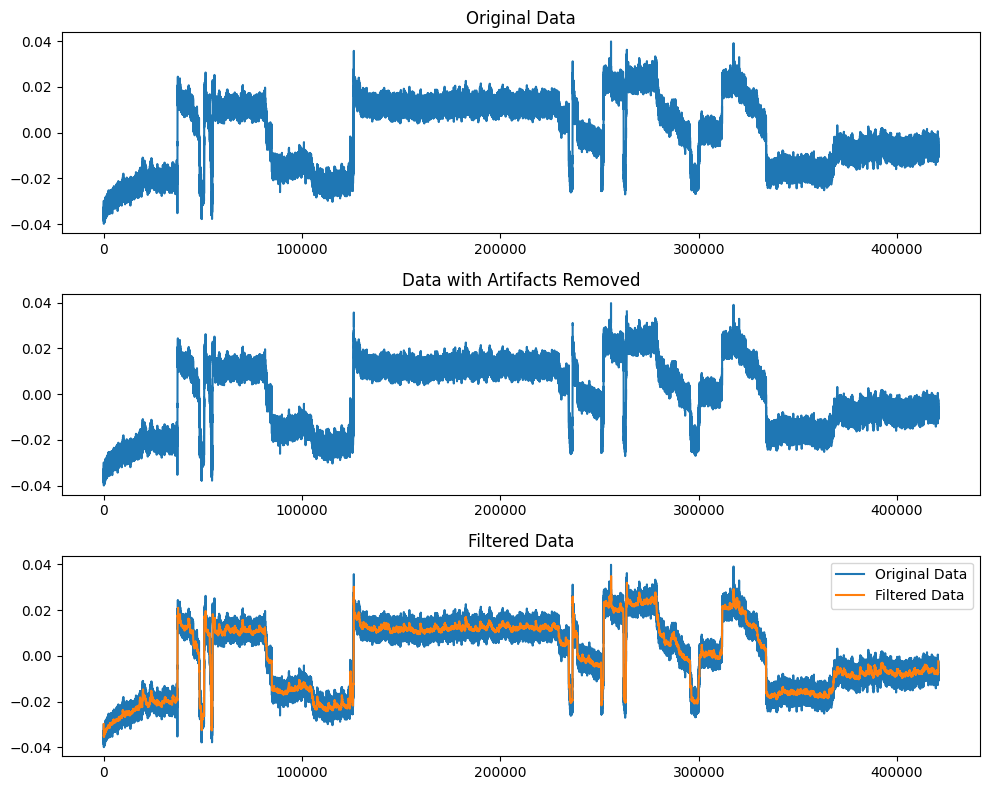

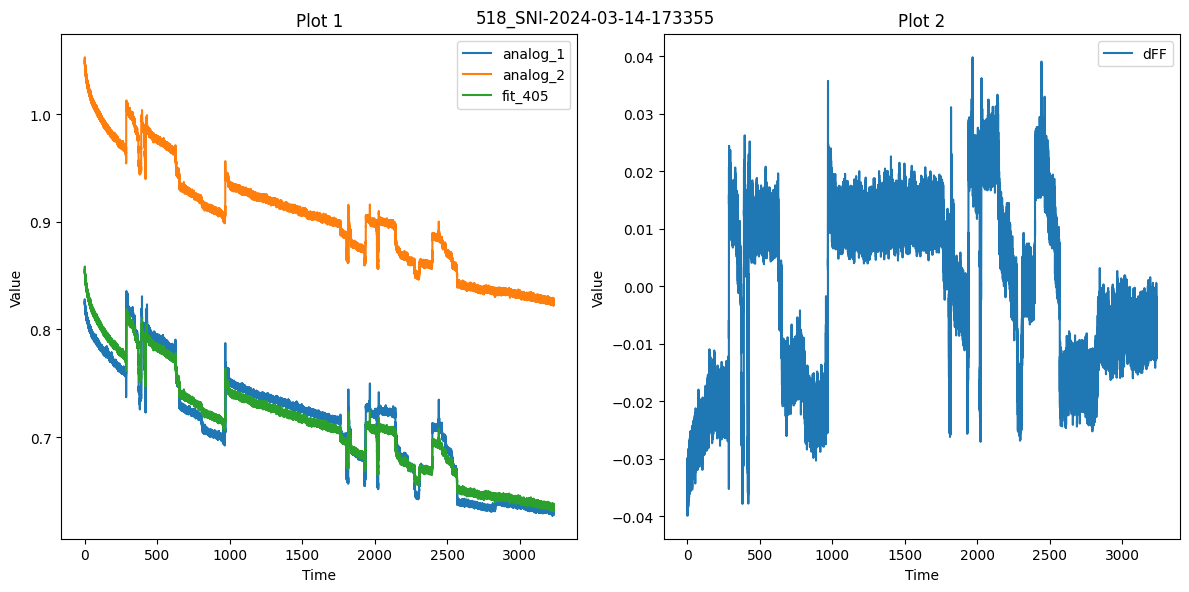

index: (array([1363, 1493]),)


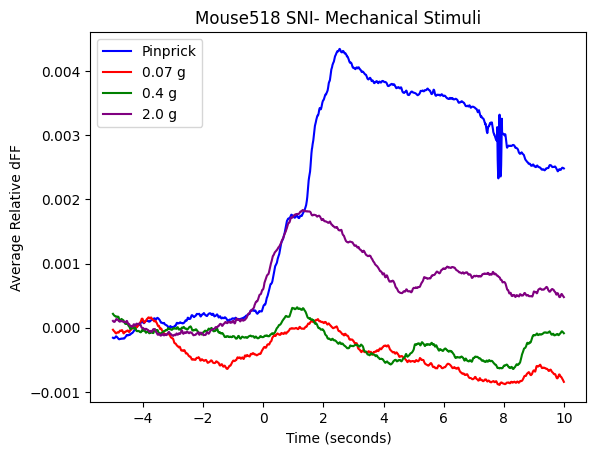

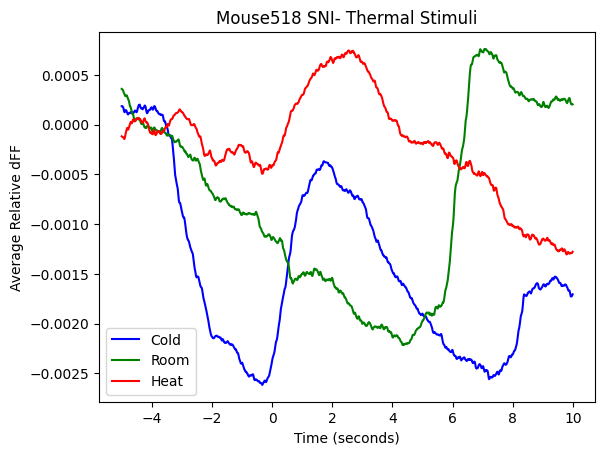

In [67]:

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

ori_data = dFF
# Detrend data
detrend_data = dFF

data_to_choose = 'detrend'  # 'original' or 'detrend'
what_to_save = 'original_fixed'
use_nan = True  # True for NaN, False for zeros

if data_to_choose == 'original':
    data_pre = ori_data
    thr = 1
elif data_to_choose == 'detrend':
    data_pre = detrend_data
    thr = 2.5

# Calculate the standard deviation of the signal
signal_std = np.std(data_pre)
threshold = thr * signal_std
range_ = 50

# Find peaks
peaks, _ = find_peaks(data_pre, prominence=threshold)

data_fixed = np.copy(data_pre)

for loc in peaks:
    search_region = np.arange(max(1, loc - range_), min(len(data_pre), loc + range_ * 2))
    diff_region = np.diff(data_pre[search_region])
    locfs, _ = find_peaks(-diff_region, prominence=3*np.std(diff_region))
    
    for locf in locfs:
        # Adjust this section to correctly find zc_before and zc_after
        zc_before = locf - range_
        zc_after = locf + range_
        
        # Ensure zc_before and zc_after are within valid range
        zc_before = max(1, zc_before)
        zc_after = min(len(diff_region), zc_after)
        
        zc_bounds = np.arange(zc_before, zc_after)
        sign_change = np.diff(np.sign(diff_region[zc_bounds]))
        zero_crossings = zc_bounds[:-1][sign_change != 0]
        
        # Fix for determining the start and end indices
        if zero_crossings.size > 0:
            zero_crossing_before = zero_crossings[zero_crossings < loc]
            zero_crossing_after = zero_crossings[zero_crossings > loc]
            
            if zero_crossing_before.size > 0:
                start_idx = search_region[zero_crossing_before[-1]]
            else:
                start_idx = max(1, loc - range_)
            
            if zero_crossing_after.size > 0:
                end_idx = search_region[zero_crossing_after[0]]
            else:
                end_idx = min(len(data_pre), loc + range_)
        else:
            start_idx = max(1, loc - range_)
            end_idx = min(len(data_pre), loc + range_)

        # Replace the data between start_idx and end_idx
        if use_nan:
            data_fixed[start_idx:end_idx+1] = np.nan
        else:
            data_fixed[start_idx:end_idx+1] = 0

# Apply median filter
window_size = 105
filtered_signal = medfilt(data_fixed, window_size)
dFF = filtered_signal

# Plotting
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(data_pre, label='Original Data')
plt.title('Original Data')
plt.subplot(3, 1, 2)
plt.plot(data_fixed, label='Data with Artifacts Removed')
plt.title('Data with Artifacts Removed')
plt.subplot(3, 1, 3)
plt.plot(data_pre, label='Original Data')
plt.plot(filtered_signal, label='Filtered Data')
plt.title('Filtered Data')
plt.legend()
plt.tight_layout()
plt.show()


# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


# Index of np.diff(data['digital_1']) bigger than 0.5 or smaller than -0.5
index = np.where((np.diff(data['digital_1']) > 0.5) | (np.diff(data['digital_1']) < -0.5))

# Print the onsets and offsets
print("index:", index)

dFF = dFF[index[0][0]:]

## 
fps = 30
excel_data['Time'] = ((excel_data['Frame'] - ledonset) / fps).astype(str)

# Organize data into a dictionary
data_mice= {
    'Mouse': {
        'Stim': excel_data['Stim'].tolist(),
        'Time': excel_data['Time'].tolist()
    }
}

# Use `data` as needed in your analysis

stim_data = data_mice['Mouse']['Stim']
time_stamps = data_mice['Mouse']['Time']
sampling_rate = 130
fps = 30

pinp_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
weak_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]
mild_indexes = [i for i, stim in enumerate(stim_data) if stim == 2]
hard_indexes = [i for i, stim in enumerate(stim_data) if stim == 3]
cold_indexes = [i for i, stim in enumerate(stim_data) if stim == 4]
room_indexes = [i for i, stim in enumerate(stim_data) if stim == 5]
warm_indexes = [i for i, stim in enumerate(stim_data) if stim == 6]

pinp_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in pinp_indexes]
weak_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in weak_indexes]
mild_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in mild_indexes]
hard_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in hard_indexes]
cold_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in cold_indexes]
room_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in room_indexes]
warm_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in warm_indexes]


trace_duration = 5  # 5 seconds before and 30 seconds after each data index

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Function to analyze and plot data for different index sets
def analyze_and_plot(indexes, dFF, sampling_rate, pre_start=pre_start, post_start=post_start):
    trace_data_matrix = []

    for index in indexes:
        start = int(index - pre_start * sampling_rate)
        end = int(index + post_start * sampling_rate)
        trace_data = dFF[start:end]
        time = np.arange(start, end) / sampling_rate

        # Calculate the baseline value
        baseline_start = int(index - 5 * sampling_rate)
        baseline_end = int(index - 3 * sampling_rate)
        baseline = np.nanmean(dFF[baseline_start:baseline_end])

        # Compute the relative trace data
        relative_trace_data = trace_data - baseline

        # Append relative_trace_data to the matrix
        trace_data_matrix.append(relative_trace_data)


    return np.array(trace_data_matrix)

# Example usage for each data index set
trace_data_matrix_pinp = analyze_and_plot(pinp_data_indexes, dFF, sampling_rate)
trace_data_matrix_weak = analyze_and_plot(weak_data_indexes, dFF, sampling_rate)
trace_data_matrix_mild = analyze_and_plot(mild_data_indexes, dFF, sampling_rate)
trace_data_matrix_hard = analyze_and_plot(hard_data_indexes, dFF, sampling_rate)
trace_data_matrix_cold = analyze_and_plot(cold_data_indexes, dFF, sampling_rate)
trace_data_matrix_room = analyze_and_plot(room_data_indexes, dFF, sampling_rate)
trace_data_matrix_warm = analyze_and_plot(warm_data_indexes, dFF, sampling_rate)

# Calculate the average trace for water and TMT
average_trace_pinp = np.nanmean(trace_data_matrix_pinp, axis=0)
average_trace_weak = np.nanmean(trace_data_matrix_weak, axis=0)
average_trace_mild = np.nanmean(trace_data_matrix_mild, axis=0)
average_trace_hard = np.nanmean(trace_data_matrix_hard, axis=0)

average_trace_pinp = savgol_filter(np.nanmean(trace_data_matrix_pinp, axis=0), window_length=11, polyorder=2)
average_trace_weak = savgol_filter(np.nanmean(trace_data_matrix_weak, axis=0), window_length=11, polyorder=2)
average_trace_mild = savgol_filter(np.nanmean(trace_data_matrix_mild, axis=0), window_length=11, polyorder=2)
average_trace_hard = savgol_filter(np.nanmean(trace_data_matrix_hard, axis=0), window_length=11, polyorder=2)


plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_pinp, label='Pinprick', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_weak, label='0.07 g', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_mild, label='0.4 g', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_hard, label='2.0 g', color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse' + mouse_name  + '- Mechanical Stimuli')
plt.legend()
plt.show()


# Calculate the average trace for water and TMT
average_trace_cold = np.nanmean(trace_data_matrix_cold, axis=0)
average_trace_room = np.nanmean(trace_data_matrix_room, axis=0)
average_trace_warm = np.nanmean(trace_data_matrix_warm, axis=0)

average_trace_cold = savgol_filter(np.nanmean(trace_data_matrix_cold, axis=0), window_length=11, polyorder=2)
average_trace_room = savgol_filter(np.nanmean(trace_data_matrix_room, axis=0), window_length=11, polyorder=2)
average_trace_warm = savgol_filter(np.nanmean(trace_data_matrix_warm, axis=0), window_length=11, polyorder=2)


plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_cold, label='Cold', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_room, label='Room', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_warm, label='Heat', color='red')


plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse' + mouse_name  + '- Thermal Stimuli')
plt.legend()
plt.show()



In [51]:
traces = {
    'average_trace_pinp': average_trace_pinp,
    'average_trace_weak': average_trace_weak,
    'average_trace_mild': average_trace_mild,
    'average_trace_hard': average_trace_hard,
    'average_trace_cold': average_trace_cold,
    'average_trace_room': average_trace_room,
    'average_trace_warm': average_trace_warm,
}

# Define the file path and name
save_file_path = r'C:\files\data\sensory_stim\519.npy'

# Save the dictionary to a NumPy file
np.save(save_file_path, traces)

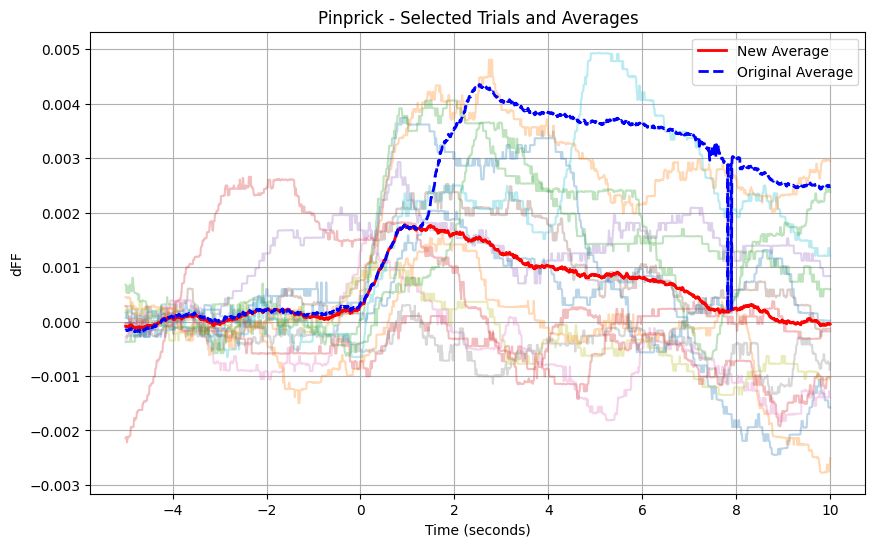

In [69]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class DataExplorer:
    def __init__(self, master):
        self.master = master
        self.master.title("Data Explorer")

        # Dictionary to map stimulus types to their respective data
        self.data_matrices = {
            'Pinprick': trace_data_matrix_pinp,
            'Weak': trace_data_matrix_weak,
            'Mild': trace_data_matrix_mild,
            'Hard': trace_data_matrix_hard,
            'Cold': trace_data_matrix_cold,
            'Room': trace_data_matrix_room,
            'Warm': trace_data_matrix_warm,
        }

        # Initialize the average traces using the original data
        self.average_traces = {
            'Pinprick': np.nanmean(self.data_matrices['Pinprick'], axis=0),
            'Weak': np.nanmean(self.data_matrices['Weak'], axis=0),
            'Mild': np.nanmean(self.data_matrices['Mild'], axis=0),
            'Hard': np.nanmean(self.data_matrices['Hard'], axis=0),
            'Cold': np.nanmean(self.data_matrices['Cold'], axis=0),
            'Room': np.nanmean(self.data_matrices['Room'], axis=0),
            'Warm': np.nanmean(self.data_matrices['Warm'], axis=0),
        }

        self.selected_trials = {stim_type: [] for stim_type in self.data_matrices.keys()}

        self.create_widgets()

    def create_widgets(self):
        # Dropdown for Stimulus Type
        self.stimulus_label = tk.Label(self.master, text="Select Stimulus Type:")
        self.stimulus_label.grid(row=0, column=0, padx=10, pady=5)

        self.stimulus_var = tk.StringVar()
        self.stimulus_dropdown = ttk.Combobox(self.master, textvariable=self.stimulus_var, state="readonly", values=list(self.data_matrices.keys()))
        self.stimulus_dropdown.grid(row=0, column=1, padx=10, pady=5)
        self.stimulus_dropdown.bind("<<ComboboxSelected>>", self.update_plot)

        # Frame for trial checkboxes
        self.trial_frame = tk.Frame(self.master)
        self.trial_frame.grid(row=1, column=0, columnspan=2, padx=10, pady=5, sticky="ew")

        # Figure for plotting
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.master)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.grid(row=2, column=0, columnspan=2, padx=10, pady=5)

        # Button to save updated average traces
        self.save_button = tk.Button(self.master, text="Save Updated Averages", command=self.save_averages)
        self.save_button.grid(row=3, column=0, columnspan=2, padx=10, pady=5)

    def create_trial_checkboxes(self):
        for widget in self.trial_frame.winfo_children():
            widget.destroy()

        stimulus_type = self.stimulus_var.get()
        num_trials = self.data_matrices[stimulus_type].shape[0]

        for i in range(num_trials):
            var = tk.BooleanVar(value=i in self.selected_trials[stimulus_type])
            cb = tk.Checkbutton(self.trial_frame, text=f"Trial {i+1}", variable=var, command=lambda i=i, var=var: self.toggle_trial(stimulus_type, i, var.get()))
            cb.grid(row=i//10, column=i%10, sticky="w")

    def toggle_trial(self, stimulus_type, trial_index, is_selected):
        if is_selected:
            self.selected_trials[stimulus_type].append(trial_index)
        else:
            self.selected_trials[stimulus_type].remove(trial_index)
        self.update_plot()

    def update_plot(self, event=None):
        stimulus_type = self.stimulus_var.get()

        if stimulus_type:
            self.create_trial_checkboxes()

            self.ax.clear()
            sampling_rate = 130
            time_vector = np.linspace(-5, 10, self.data_matrices[stimulus_type].shape[1])

            # Plot individual selected trials
            for trial in self.selected_trials[stimulus_type]:
                data = self.data_matrices[stimulus_type][trial, :]
                self.ax.plot(time_vector, data, alpha=0.3)

            # Calculate and plot new average if there are selected trials
            if self.selected_trials[stimulus_type]:
                new_avg = np.mean(self.data_matrices[stimulus_type][self.selected_trials[stimulus_type], :], axis=0)
                self.average_traces[stimulus_type] = new_avg  # Update the average traces
                self.ax.plot(time_vector, new_avg, color='red', linewidth=2, label='New Average')

            # Plot original average
            self.ax.plot(time_vector, np.nanmean(self.data_matrices[stimulus_type], axis=0), color='blue', linewidth=2, linestyle='--', label='Original Average')

            self.ax.set_title(f"{stimulus_type} - Selected Trials and Averages")
            self.ax.set_xlabel("Time (seconds)")
            self.ax.set_ylabel("dFF")
            self.ax.grid(True)
            self.ax.legend()

            self.canvas.draw()

    def save_averages(self):
        # Ensure we're saving the latest averages, including any updates from selected trials
        traces = {
            'average_trace_pinp': self.average_traces['Pinprick'],
            'average_trace_weak': self.average_traces['Weak'],
            'average_trace_mild': self.average_traces['Mild'],
            'average_trace_hard': self.average_traces['Hard'],
            'average_trace_cold': self.average_traces['Cold'],
            'average_trace_room': self.average_traces['Room'],
            'average_trace_warm': self.average_traces['Warm'],
        }

        # Define the file path and name
        save_file_path = r'C:\files\data\sensory_stim\516.npy'

        # Save the dictionary to a NumPy file
        np.save(save_file_path, traces)
        print(f"Updated averages saved to {save_file_path}")

def main():
    root = tk.Tk()
    app = DataExplorer(root)
    root.mainloop()

if __name__ == "__main__":
    main()


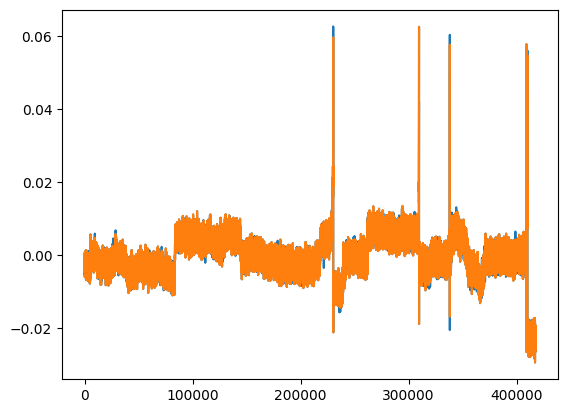

In [19]:
import numpy as np
from scipy.signal import medfilt

def apply_median_filter(dFF, kernel_size=10):
    """
    Apply a median filter to the signal to remove spikes (artifacts).

    Parameters:
    - dFF: The original signal with potential artifacts.
    - kernel_sizC:\files\data The size of the kernel used in the median filter.

    Returns:
    - The signal with artifacts reduced by the median filter.
    """
    filtered_signal = medfilt(dFF, kernel_size=kernel_size)
    return filtered_signal

# Replace 'your_data_array' with the actual data array you have
corrected_dFF = apply_median_filter(dFF, kernel_size=5)
plt.plot(dFF)
plt.plot(corrected_dFF)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the new dFF data from the CSV file provided by the user
dFF_data = data['analog_1']

# We will now define a function that identifies the abrupt changes (artifacts) in the signal
# and then drags the signal after the artifact to the level of the signal just before the artifact.
# After this, it will interpolate to smooth out any remaining discontinuities.

def remove_artifacts_and_drag(dFF_series, z_thresh=10, window=50):
    """
    This function removes artifacts from a signal by identifying points with a z-score
    above a certain threshold, then dragging the subsequent signal to match the level
    just before the artifact, followed by interpolation.
    
    Args:
    - dFF_series (pd.Series): The original dFF signal.
    - z_thresh (float): The threshold for the z-score to identify artifacts.
    - window (int): The rolling window size to calculate the median and standard deviation.
    
    Returns:
    - pd.Series: The dFF signal with artifacts removed.
    """
    # Calculate the rolling median and standard deviation for z-score computation
    rolling_median = dFF_series.rolling(window=window, center=True).median()
    rolling_std = dFF_series.rolling(window=window, center=True).std()
    # Replace NaN values which arise from rolling calculation at the start and end of the series
    rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
    rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')

    # Calculate z-scores
    z_scores = (dFF_series - rolling_median) / rolling_std
    
    # Identify indices of the artifacts based on the z-score threshold
    artifact_indices = np.where(np.abs(z_scores) > z_thresh)[0]
    
    # Create a copy of the dFF_series to correct
    corrected_signal = dFF_series.copy()

    # Adjust the levels by dragging the signal after the artifacts
    for idx in artifact_indices:
        if idx < len(dFF_series) - 1:
            # Calculate the level difference
            level_difference = corrected_signal.iloc[idx] - corrected_signal.iloc[idx + 1]
            # Drag the levels after the artifact index
            corrected_signal.iloc[idx + 1:] += level_difference

    # Interpolate over the actual artifact points
    corrected_signal[artifact_indices] = np.nan
    corrected_signal.interpolate(inplace=True)

    return corrected_signal

# Clean the dFF signal using the function defined
cleaned_dFF_series = remove_artifacts_and_drag(dFF_data['dFF'])

# Plotting the original and cleaned dFF signals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(dFF_data['dFF'], label='Original dFF')
plt.title('Original dFF Signal')
plt.xlabel('Samples')
plt.ylabel('dFF')

plt.subplot(1, 2, 2)
plt.plot(cleaned_dFF_series, label='Cleaned dFF', color='orange')
plt.title('Cleaned dFF Signal After Dragging')
plt.xlabel('Samples')
plt.ylabel('dFF')

plt.legend()
plt.tight_layout()
plt.show()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [26]:
# Convert the array into a pandas DataFrame
dFF_df = pd.DataFrame(data['analog_1'], columns=['dFF'])

# Save the DataFrame to a CSV file
csv_file_path = 'dFF_data.csv'  # Specify your desired file path and name
dFF_df.to_csv(csv_file_path, index=False)

csv_file_path  # This will output the file path which can be used to download the file


'dFF_data.csv'

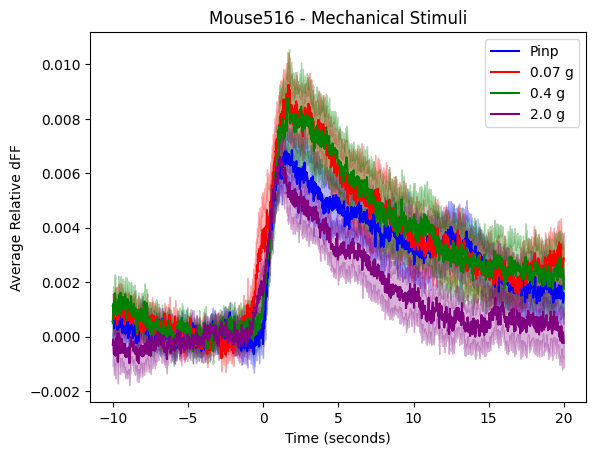

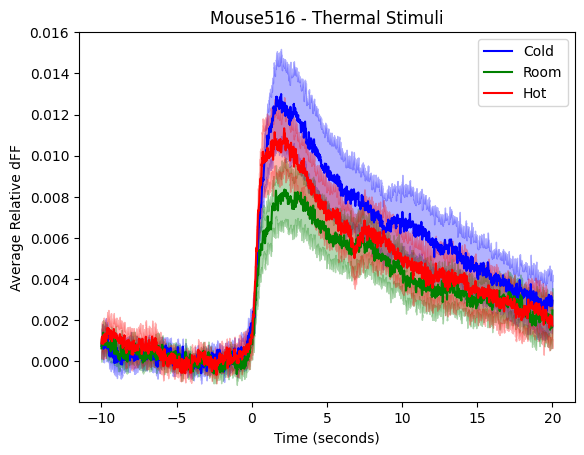

In [29]:
# Function to calculate SEM
def calculate_sem(trace_data_matrix):
    n = len(trace_data_matrix)
    sd = np.std(trace_data_matrix, axis=0)
    return sd / np.sqrt(n)

# Calculate SEM for each condition
sem_pinp = calculate_sem(trace_data_matrix_pinp)
sem_weak = calculate_sem(trace_data_matrix_weak)
sem_mild = calculate_sem(trace_data_matrix_mild)
sem_hard = calculate_sem(trace_data_matrix_hard)
sem_cold = calculate_sem(trace_data_matrix_cold)
sem_room = calculate_sem(trace_data_matrix_room)
sem_warm = calculate_sem(trace_data_matrix_warm)

# Time vector for plotting
time_vector = np.arange(-pre_start, post_start, 1/sampling_rate)

# Function to plot with shading
def plot_with_shading(time_vector, average_trace, sem_trace, label, color):
    plt.plot(time_vector, average_trace, label=label, color=color)
    plt.fill_between(time_vector, average_trace - sem_trace, average_trace + sem_trace, color=color, alpha=0.3)

# Plotting with shading for mechanical stimuli
plt.figure()
plot_with_shading(time_vector, average_trace_pinp, sem_pinp, 'Pinp', 'blue')
plot_with_shading(time_vector, average_trace_weak, sem_weak, '0.07 g', 'red')
plot_with_shading(time_vector, average_trace_mild, sem_mild, '0.4 g', 'green')
plot_with_shading(time_vector, average_trace_hard, sem_hard, '2.0 g', 'purple')

# Common plot settings for mechanical stimuli
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse516 - Mechanical Stimuli')
plt.legend()
plt.show()

# Plotting with shading for thermal stimuli
plt.figure()
plot_with_shading(time_vector, average_trace_cold, sem_cold, 'Cold', 'blue')
plot_with_shading(time_vector, average_trace_room, sem_room, 'Room', 'green')
plot_with_shading(time_vector, average_trace_warm, sem_warm, 'Hot', 'red')

# Common plot settings for thermal stimuli
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse516 - Thermal Stimuli')
plt.legend()
plt.show()

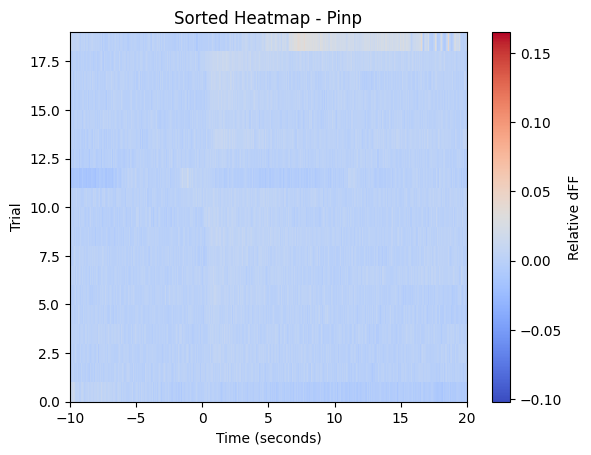

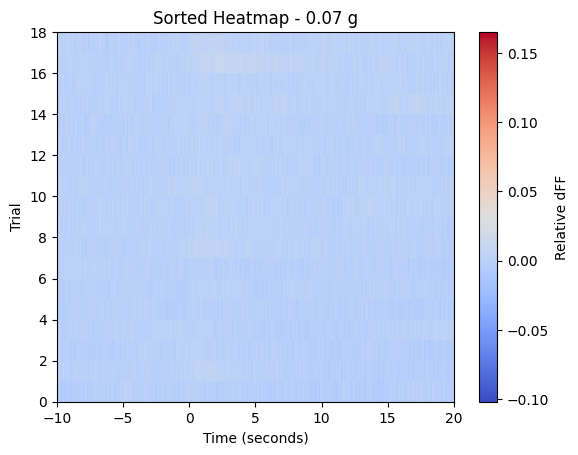

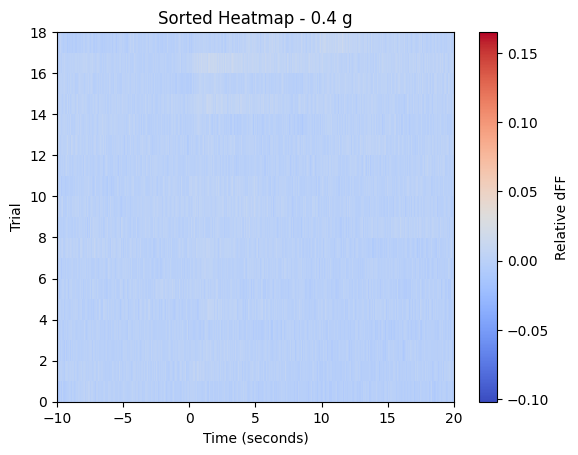

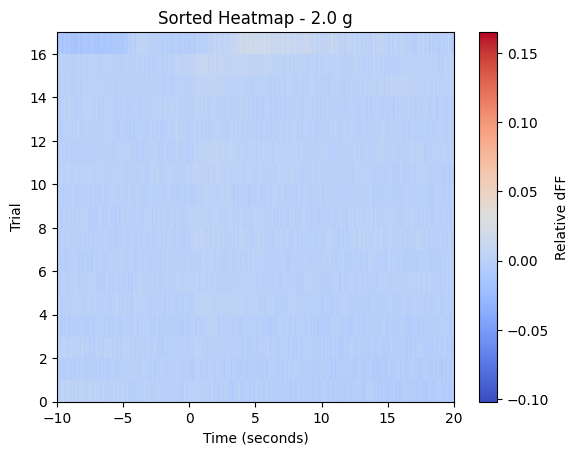

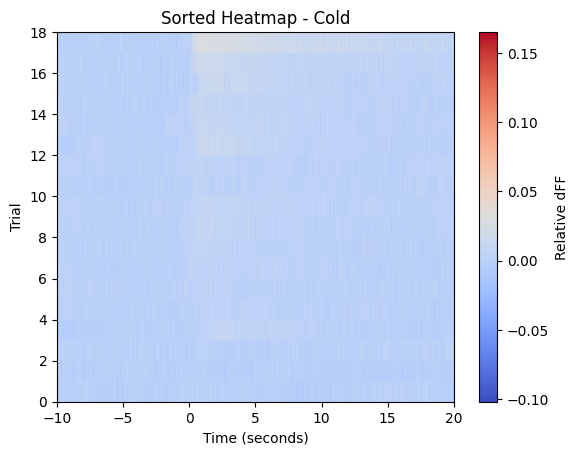

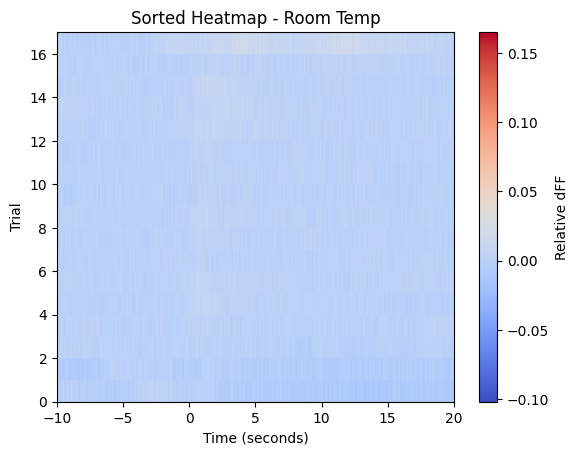

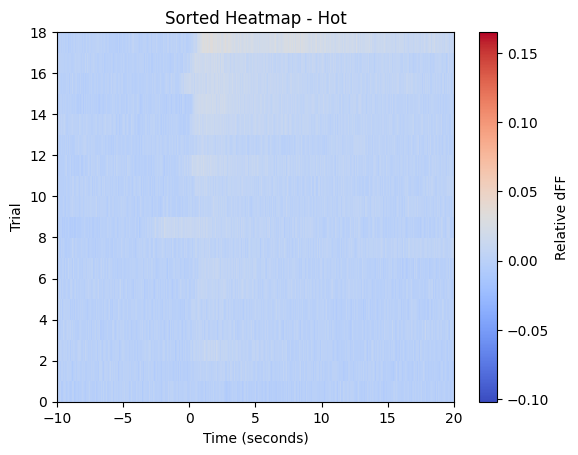

In [20]:
def plot_sorted_heatmap(data_matrix, title, pre_start, post_start, sampling_rate, vmin, vmax):
    # Calculate the average activity in the 0-2 second post-start period
    post_start_index = int(post_start * sampling_rate)
    post_end_index = int((post_start + 2) * sampling_rate)
    avg_activity = np.mean(data_matrix[:, post_start_index:post_end_index], axis=1)

    # Sort the data matrix based on the average activity (high to low)
    sorted_indexes = np.argsort(-avg_activity)
    sorted_data_matrix = data_matrix[sorted_indexes]

    # Plot the heatmap
    extent = [-pre_start, post_start, 0, sorted_data_matrix.shape[0]]
    plt.imshow(sorted_data_matrix, aspect='auto', extent=extent, cmap='coolwarm',
               interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Relative dFF')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Trial')
    plt.title(title)
    plt.show()

# Plotting heatmaps with consistent color scaling and sorted rows
plot_sorted_heatmap(trace_data_matrix_pinp, 'Sorted Heatmap - Pinp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_weak, 'Sorted Heatmap - 0.07 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_mild, 'Sorted Heatmap - 0.4 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_hard, 'Sorted Heatmap - 2.0 g', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_cold, 'Sorted Heatmap - Cold', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_room, 'Sorted Heatmap - Room Temp', pre_start, post_start, sampling_rate, min_val, max_val)
plot_sorted_heatmap(trace_data_matrix_warm, 'Sorted Heatmap - Hot', pre_start, post_start, sampling_rate, min_val, max_val)
